In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import Config
import datetime
import time
import copy
import BS

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score

from pymongo import MongoClient
client=MongoClient(Config.DB_Hostname,Config.DB_Port)

def _calc_option_price(S, K, T, r, future, vol_neg3, vol_neg2, vol_neg1, vol_0, vol_pos1, vol_pos2, vol_pos3, call = True):
    
    moneyness_percent = 100*(K/future - 1)
    
    if moneyness_percent <= -2:
        sigma = vol_neg2 + (vol_neg2 - vol_neg3) * (moneyness_percent + 2)
    
    elif moneyness_percent >= -2 and moneyness_percent <= -1:
        sigma = vol_neg1 + (vol_neg1 - vol_neg2) * (moneyness_percent + 1)

    elif moneyness_percent >= -1 and moneyness_percent <= 0:
        sigma = vol_0 + (vol_0 - vol_neg1) * (moneyness_percent)

    elif moneyness_percent >= 0 and moneyness_percent <= 1:
        sigma = vol_pos1 + (vol_pos1 - vol_0) * (moneyness_percent - 1)

    elif moneyness_percent >= 1 and moneyness_percent <= 2:
        sigma = vol_pos2 + (vol_pos2 - vol_pos1) * (moneyness_percent - 2)

    else:
        sigma = vol_pos3 + (vol_pos3 - vol_pos2) * (moneyness_percent - 3)
    
    if call:
        return BS.bs_call(S,K,T,r,sigma)

    else:
        return BS.bs_put(S,K,T,r,sigma)
    
    
def _calc_spread_return(spot, long_start, long_end, short_start, short_end, strike_spread):
    
    spread_benefit = short_start - long_start
    margin = spot*0.02 - spread_benefit
    brokerage = (long_start + long_end + short_start + short_end) * 0.001
    
    if spread_benefit > 0:
        margin += strike_spread
        
    if margin <0:
        print(f"Error_{margin}")
    
    return (long_end - long_start + short_start - short_end - brokerage)/margin


class Gap_Move_Classifier:
    
    def __init__(self, start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period):
        
        self.start_date = start_date #2017-01-01
        self.end_date = end_date #2017-01-01
        self.prediction_date = prediction_date #2017-01-01
        self.underlying = underlying #NIFTY, BANKNIFTY
        self.underlying_dynamics = None
        self.vol_surface = None
        self.days_to_expiry = None
        self.data_matrix = None
        self.return_matrix = None
        self.price_matrix = None
        self.performance_stats = None
        self.start_holding_period = start_holding_period #in minutes
        self.end_holding_period = end_holding_period #in minutes
        self.strike_range = [-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
        
        #start = time.time()
        self.underlying_dynamics = pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}OHLC'].find())
        self.underlying_dynamics.drop(columns=['_id'],inplace=True)
        self.underlying_dynamics.sort_values(['date','batch_id'],inplace=True)
        self.underlying_dynamics=self.underlying_dynamics[(self.underlying_dynamics.date>=self.start_date)&(self.underlying_dynamics.date<=self.end_date)]
        self.underlying_dynamics.batch_id=self.underlying_dynamics.batch_id.astype(int)
        self.underlying_dynamics.set_index('date',inplace=True)
        #print(f"Prices Downloaded in {time.time() - start} seconds")

        #start=time.time()
        self.vol_surface=pd.DataFrame(client[f'{Config.Data_DB}']['Vol_Surface'].find({"SYMBOL" : self.underlying}))
        self.vol_surface=self.vol_surface[['vol_neg3', 'vol_neg2', 'vol_neg1', 'vol_0', 'vol_pos1', 'vol_pos2', 'vol_pos3', 'date']]
        self.vol_surface.sort_values('date',inplace=True)
        self.vol_surface=self.vol_surface[(self.vol_surface.date>=self.start_date)&(self.vol_surface.date<=self.end_date)]
        self.vol_surface.set_index('date',inplace=True)
        
        for col in self.vol_surface.columns:
            self.vol_surface[col] = np.where(self.vol_surface[col] < 0.02, np.nan, self.vol_surface[col])

        self.vol_surface.bfill(axis = 1, inplace = True)
        self.vol_surface.ffill(axis = 1, inplace = True)
        #print(f"Vol Surface Downloaded in {time.time() - start} seconds")
        
        #start=time.time()
        self.days_to_expiry = pd.DataFrame(client[f'{Config.Data_DB}']['Days_To_Expiry'].find({"underlying":self.underlying}))
        self.days_to_expiry.drop(columns = ['_id','underlying'],inplace=True)
        self.days_to_expiry.sort_values('date',inplace=True)
        self.days_to_expiry=self.days_to_expiry[(self.days_to_expiry.date>=self.start_date)&(self.days_to_expiry.date<=self.end_date)]
        self.days_to_expiry.set_index('date',inplace=True)
        #print(f"Expiry Dates Downloaded in {time.time()-start} seconds")

        #start=time.time()
        self._make_features()
        #print(f"Features Engineered in {time.time() - start} seconds")

        #start=time.time()
        self._generate_return_matrix()
        #print(f"Features Engineered in {time.time() - start} seconds")
                
    def _make_features(self):
        
        vol_surface = copy.deepcopy(self.vol_surface)
        if self.end_date not in vol_surface.index:
            vol_surface.loc[self.end_date] = [np.nan]*len(vol_surface.columns)

        closing_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==375 - (self.start_holding_period - 1)][['open']]
        if self.end_date not in closing_candle.index:
            closing_candle.loc[self.end_date] = np.nan
        closing_candle=closing_candle.shift()
        
        opening_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==1 + (self.end_holding_period - 1)][['close']]
        if self.end_date not in opening_candle.index:
            opening_candle.loc[self.end_date] = np.nan
        
        candle = pd.merge(closing_candle, opening_candle, left_index=True, right_index=True)
        candle.close = np.where(candle.close.isna(), candle.open, candle.close)
        
        self.data_matrix = pd.DataFrame()
        self.data_matrix["gap_move"] = (candle.close - candle.open) / candle.open
        self.data_matrix["gap_move_flag"] = np.where(self.data_matrix.gap_move>=0, 1, 0)
        self.data_matrix = pd.merge(self.data_matrix, vol_surface.shift(), left_index = True, right_index = True).dropna()
        
        candle = pd.merge(candle, vol_surface.shift(), left_index=True, right_index=True)        
        candle = pd.merge(candle, self.days_to_expiry, left_index=True, right_index=True)
        candle = pd.merge(candle , 
                          self.days_to_expiry.shift().rename(columns = 
                            {"current_week" : "current_week_yesterday", "next_week": "next_week_yesterday"}), 
                          left_index=True,
                          right_index=True)
        
        candle.current_week_yesterday = np.where(candle.current_week_yesterday == 1, candle.next_week_yesterday, candle.current_week_yesterday)
        
        candle["entry_time"] = (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365
        candle["exit_time"] = (candle.current_week - 0.75 - self.end_holding_period/1440) / 365
        candle["future_open"] = candle.open * np.exp(Config.interest_rate * candle.entry_time)
        candle["future_close"] = candle.close * np.exp(Config.interest_rate * candle.exit_time)
        candle.dropna(inplace = True)
        
        for strike_range in self.strike_range:
            
            candle[f"{strike_range}_strike_call_and_put"] = candle.open * (1 + strike_range/100) * np.exp(Config.interest_rate * (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365)
            
            candle[f"call_{strike_range}_yesterday"] = candle.apply(lambda x : _calc_option_price(x.open, 
                                                                                                  x[f"{strike_range}_strike_call_and_put"], 
                                                                                                  x["entry_time"], 
                                                                                                  Config.interest_rate, 
                                                                                                  x["future_open"], 
                                                                                                  x["vol_neg3"], 
                                                                                                  x["vol_neg2"], 
                                                                                                  x["vol_neg1"], 
                                                                                                  x["vol_0"], 
                                                                                                  x["vol_pos1"], 
                                                                                                  x["vol_pos2"],
                                                                                                  x["vol_pos3"], 
                                                                                                  call = True), axis = 1)
            
            candle[f"call_{strike_range}_today"] = candle.apply(lambda x : _calc_option_price(x.close, 
                                                                                              x[f"{strike_range}_strike_call_and_put"],
                                                                                              x["exit_time"],
                                                                                              Config.interest_rate,
                                                                                              x["future_close"], 
                                                                                              x["vol_neg3"], 
                                                                                              x["vol_neg2"], 
                                                                                              x["vol_neg1"], 
                                                                                              x["vol_0"], 
                                                                                              x["vol_pos1"], 
                                                                                              x["vol_pos2"],
                                                                                              x["vol_pos3"], 
                                                                                              call = True), axis = 1)

            candle[f"put_{strike_range}_yesterday"] = candle.apply(lambda x : _calc_option_price(x.open, 
                                                                                                 x[f"{strike_range}_strike_call_and_put"],
                                                                                                 x["entry_time"],
                                                                                                 Config.interest_rate,
                                                                                                 x["future_open"], 
                                                                                                 x["vol_neg3"], 
                                                                                                 x["vol_neg2"], 
                                                                                                 x["vol_neg1"], 
                                                                                                 x["vol_0"], 
                                                                                                 x["vol_pos1"], 
                                                                                                 x["vol_pos2"],
                                                                                                 x["vol_pos3"], 
                                                                                                 call = False), axis = 1)
            
            candle[f"put_{strike_range}_today"] = candle.apply(lambda x : _calc_option_price(x.close, 
                                                                                              x[f"{strike_range}_strike_call_and_put"],
                                                                                              x["exit_time"],
                                                                                              Config.interest_rate,
                                                                                              x["future_close"], 
                                                                                              x["vol_neg3"], 
                                                                                              x["vol_neg2"], 
                                                                                              x["vol_neg1"], 
                                                                                              x["vol_0"], 
                                                                                              x["vol_pos1"], 
                                                                                              x["vol_pos2"],
                                                                                              x["vol_pos3"], 
                                                                                              call = False), axis = 1)
                            
        self.price_matrix = candle[(candle.columns[candle.columns.str.contains('call')])| (candle.columns[candle.columns.str.contains('put')]) ]
        self.price_matrix["open"] = candle[['open']]
        self.price_matrix["current_week_yesterday"] = candle[['current_week_yesterday']]
        
    def _generate_return_matrix(self):
        
        self.return_matrix = pd.DataFrame({"date":sorted(self.price_matrix.index)}).set_index('date')
        for index, strike_range_lower in enumerate(self.strike_range[:-1]):
            for strike_range_upper in self.strike_range[index+1:]:

                call_long_yesterday = f"call_{strike_range_lower}_yesterday"
                call_long_today = f"call_{strike_range_lower}_today"
                call_short_yesterday = f"call_{strike_range_upper}_yesterday"
                call_short_today = f"call_{strike_range_upper}_today"
                call_short_strike = f"{strike_range_upper}_strike_call_and_put"
                call_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                put_long_yesterday = f"put_{strike_range_lower}_yesterday"
                put_long_today = f"put_{strike_range_lower}_today"
                put_short_yesterday = f"put_{strike_range_upper}_yesterday"
                put_short_today = f"put_{strike_range_upper}_today"
                put_short_strike = f"{strike_range_upper}_strike_call_and_put"
                put_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                if strike_range_lower<=0.75:
                    self.return_matrix[f"call_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'],
                                                                                        x[call_long_yesterday], 
                                                                                        x[call_long_today], 
                                                                                        x[call_short_yesterday],
                                                                                        x[call_short_today], 
                                                                                        x[call_short_strike] - x[call_long_strike]),
                                                                                        axis=1)
                if strike_range_lower>=-0.75:
                    self.return_matrix[f"put_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'], 
                                                                                         x[put_long_yesterday], 
                                                                                         x[put_long_today],
                                                                                         x[put_short_yesterday],
                                                                                         x[put_short_today],  
                                                                                         x[put_short_strike] - x[put_long_strike]),
                                                                                         axis=1)
        
    def _generate_performance_stats(self, 
                                    tail = None, 
                                    return_matrix_user = None, 
                                    start_holding_period = None, 
                                    end_holding_period = None):
        
        if start_holding_period is not None:
            self.start_holding_period = start_holding_period
        
        if end_holding_period is not None:
            self.end_holding_period = end_holding_period
            
        if return_matrix_user is not None:
            self.return_matrix = return_matrix_user[return_matrix_user.columns[(return_matrix_user.columns.str.contains('call')) | (return_matrix_user.columns.str.contains('put'))]]

        sim = pd.DataFrame(index = self.return_matrix.columns)
        
        if tail is not None:
            self.return_matrix = self.return_matrix.tail(tail)        
        return_matrix = self.return_matrix.copy()
        
        sim["Sharpe"] = 16 * return_matrix.mean()/return_matrix.std()

        rolling_cumulative = (1 + return_matrix).rolling(60).apply(lambda x : x.prod()).dropna()
        sim["60_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["60_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["60_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["60_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        rolling_cumulative = (1 + return_matrix).rolling(250).apply(lambda x : x.prod()).dropna()
        sim["250_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["250_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["250_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["250_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        sim["Return"] = ((1 + return_matrix).cumprod().tail(1) ** (1/len(return_matrix)) - 1).mean()

        sim["Last_60_Day_Cumulative_Return"] = (1 + return_matrix).tail(60).cumprod().tail(1).mean()
        sim["Last_250_Day_Cumulative_Return"] = (1 + return_matrix).tail(250).cumprod().tail(1).mean()
        sim["MDD"] = (((1 + return_matrix).cumprod() / ((1 + return_matrix).cumprod().cummax())) - 1).min()   
        
        sim["start_holding_period"] = self.start_holding_period
        sim["end_holding_period"] = self.end_holding_period
        
        self.performance_stats = sim.copy()

In [6]:
start_date = '2015-01-09' #starting data point best left untouchedd
end_date = '2024-02-23'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
prediction_date = '2024-01-23' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
underlying = 'NIFTY' #NIFTY/BANKNIFTY
start_holding_period = 13
end_holding_period = 12
self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period)
self._generate_performance_stats()

In [7]:
self.return_matrix["put_1_1.5"]

date
2015-01-13   -0.00380
2015-01-14   -0.01152
2015-01-15    0.19223
2015-01-19    0.02440
2015-01-20    0.01124
               ...   
2024-02-19   -0.01124
2024-02-20   -0.01697
2024-02-21   -0.01141
2024-02-22   -0.00892
2024-02-23   -0.00185
Name: put_1_1.5, Length: 2248, dtype: float64

In [2]:
start_holding_period = list(range(1,31))
end_holding_period = list(range(1,31))
tail = None
return_summary = []
summary = []
for start in start_holding_period:
    for end in end_holding_period:
        
        print(start,end)
        
        start_date = '2015-01-09' #starting data point best left untouchedd
        end_date = '2024-02-15'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
        prediction_date = '2024-01-19' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
        underlying = 'NIFTY' #NIFTY/BANKNIFTY
        self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start, end)
        self._generate_performance_stats(tail=tail)
        summary.append(self.performance_stats)
        
        temp = pd.merge(self.return_matrix, self.days_to_expiry[['current_week']], left_index = True, right_index = True)
        temp["start_holding_period"] = start
        temp["end_holding_period"] = end
        return_summary.append(temp)
        
summary = pd.concat(summary)
return_summary = pd.concat(return_summary)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
7 20
7 21
7 22
7 23
7 24
7 25
7 26
7 27
7 28
7 29
7 30
8 1
8 2
8 3
8

In [3]:
vol_surface = self.vol_surface.shift().dropna()
return_summary["vol_flag"] = return_summary.index.map(vol_surface["vol_0"].to_dict())
return_summary["skew_flag"] = return_summary.index.map(((vol_surface["vol_pos1"] - vol_surface["vol_neg1"])/(2*vol_surface["vol_0"])).to_dict())
return_summary["curve_flag"] = return_summary.index.map(((vol_surface["vol_pos1"] -2*vol_surface["vol_0"] + vol_surface["vol_neg1"])/(2*vol_surface["vol_0"]*vol_surface["vol_0"])).to_dict())
return_summary.vol_flag = np.where(return_summary.vol_flag>=return_summary.vol_flag.median(),1,0)
return_summary.skew_flag = np.where(return_summary.skew_flag>=return_summary.skew_flag.median(),1,0)
return_summary.curve_flag = np.where(return_summary.curve_flag>=return_summary.curve_flag.median(),1,0)

return_summary.current_week = np.where(return_summary.current_week == 5, 4, return_summary.current_week)
return_summary.current_week = np.where(return_summary.current_week == 6, 7, return_summary.current_week)
selected_strategies = []

for vol_flag in [0,1]:
    for skew_flag in [0,1]:
        for curve_flag in [0,1]:
            for current_week in sorted(return_summary.current_week.unique()):
                print(vol_flag, skew_flag, curve_flag, current_week)

                temp = []
                for start in sorted(return_summary.start_holding_period.unique()):
                    for end in sorted(return_summary.end_holding_period.unique()):

                        self._generate_performance_stats(return_matrix_user = return_summary[(return_summary.vol_flag == vol_flag) & 
                                                                                             (return_summary.skew_flag == skew_flag) & 
                                                                                             (return_summary.curve_flag == curve_flag) & 
                                                                                             (return_summary.current_week == current_week) & 
                                                                                             (return_summary.start_holding_period == start) & 
                                                                                             (return_summary.end_holding_period == end)],
                                                         start_holding_period = start, 
                                                         end_holding_period = end)
                        temp.append(self.performance_stats)

                temp = pd.concat(temp)
                temp["current_week"] = current_week
                temp["vol_flag"] = vol_flag
                temp["skew_flag"] = skew_flag
                temp["curve_flag"] = curve_flag
                selected_strategies.append(temp.sort_values('Return', ascending=False).head(1))

selected_strategies = pd.concat(selected_strategies)
selected_strategies

0 0 0 1
0 0 0 2
0 0 0 3
0 0 0 4
0 0 0 7
0 0 1 1
0 0 1 2
0 0 1 3
0 0 1 4
0 0 1 7
0 1 0 1
0 1 0 2
0 1 0 3
0 1 0 4
0 1 0 7
0 1 1 1
0 1 1 2
0 1 1 3
0 1 1 4
0 1 1 7
1 0 0 1
1 0 0 2
1 0 0 3
1 0 0 4
1 0 0 7
1 0 1 1
1 0 1 2
1 0 1 3
1 0 1 4
1 0 1 7
1 1 0 1
1 1 0 2
1 1 0 3
1 1 0 4
1 1 0 7
1 1 1 1
1 1 1 2
1 1 1 3
1 1 1 4
1 1 1 7


,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period,current_week,vol_flag,skew_flag,curve_flag
call_-1.25_0,15.39652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03469,2.87814,2.87814,-0.08445,1,11,1,0,0,0
call_-1.5_-0.25,5.13562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00997,1.60956,1.60956,-0.12610,13,12,2,0,0,0
call_-1.5_1.5,7.08648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03199,3.30900,3.30900,-0.23485,30,30,3,0,0,0
call_-1.5_0,12.22387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02684,3.56631,3.56631,-0.13992,30,4,4,0,0,0
call_0.75_1.5,6.96721,2.55667,2.60865,2.95818,2.44121,NaN,NaN,NaN,NaN,0.01871,2.95818,3.39962,-0.26338,13,12,7,0,0,0
call_-1.5_0.25,5.30285,4.64262,4.30756,7.18739,1.58156,NaN,NaN,NaN,NaN,0.01950,1.89359,10.96837,-0.34425,1,4,1,0,0,1
call_0_1.5,4.78768,5.57333,5.56078,10.67690,2.45317,NaN,NaN,NaN,NaN,0.02556,7.16249,18.69122,-0.50688,30,24,2,0,0,1
call_0_1.5,5.30636,2.60248,2.74974,5.24906,1.32680,NaN,NaN,NaN,NaN,0.02356,5.24906,14.55834,-0.42196,1,13,3,0,0,1
call_-1.5_-1,17.25361,2.61521,2.58666,2.75699,2.22706,NaN,NaN,NaN,NaN,0.01499,2.75699,4.23638,-0.07115,28,29,4,0,0,1
call_0_1.5,4.16760,2.57437,2.66081,3.64039,1.80509,NaN,NaN,NaN,NaN,0.01965,2.79061,7.42167,-0.23303,13,16,7,0,0,1


In [4]:
selected_return_matrix = []
for strategy, start, end, current_week, vol_flag, skew_flag, curve_flag in zip(selected_strategies.index, 
                                                                               selected_strategies.start_holding_period, 
                                                                               selected_strategies.end_holding_period, 
                                                                               selected_strategies.current_week,
                                                                               selected_strategies.vol_flag,
                                                                               selected_strategies.skew_flag,
                                                                               selected_strategies.curve_flag):
    
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week) &
                    (return_summary.vol_flag == vol_flag) &
                    (return_summary.skew_flag == skew_flag) &
                    (return_summary.curve_flag == curve_flag)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,5.02174,3.58650,4.06062,13.28602,0.24962,139.33776,493.12278,5755.74284,6.03713,0.01995,6.75060,201.78449,-0.80477,30,30


In [5]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2016-01-18                1.01054
            strategy_call_and_put
date                             
2017-01-23                1.01736
            strategy_call_and_put
date                             
2018-01-25                1.02657
            strategy_call_and_put
date                             
2019-02-01                1.01287
            strategy_call_and_put
date                             
2020-02-10                1.02372
            strategy_call_and_put
date                             
2021-02-11                1.02270
            strategy_call_and_put
date                             
2022-02-17                1.02904
            strategy_call_and_put
date                             
2023-02-21                1.01487
            strategy_call_and_put
date                             
2024-02-15                1.02146


In [6]:
selected_return_matrix.describe()

,strategy_call_and_put
count,2242.00000
mean,0.02259
std,0.07196
min,-0.35485
25%,-0.01071
50%,0.02207
75%,0.06255
max,0.33682


In [35]:
(return_summary.groupby(['current_week','vol_flag','skew_flag','curve_flag']).count()[['call_-1.5_-1.25']]/900).reset_index()

,current_week,vol_flag,skew_flag,curve_flag,call_-1.5_-1.25
0,1,0,0,0,31.00000
1,1,0,0,1,124.00000
2,1,0,1,0,11.00000
3,1,0,1,1,65.00000
4,1,1,0,0,52.00000
5,1,1,0,1,27.00000
6,1,1,1,0,99.00000
7,1,1,1,1,66.00000
8,2,0,0,0,48.00000
9,2,0,0,1,116.00000


<Axes: xlabel='date'>

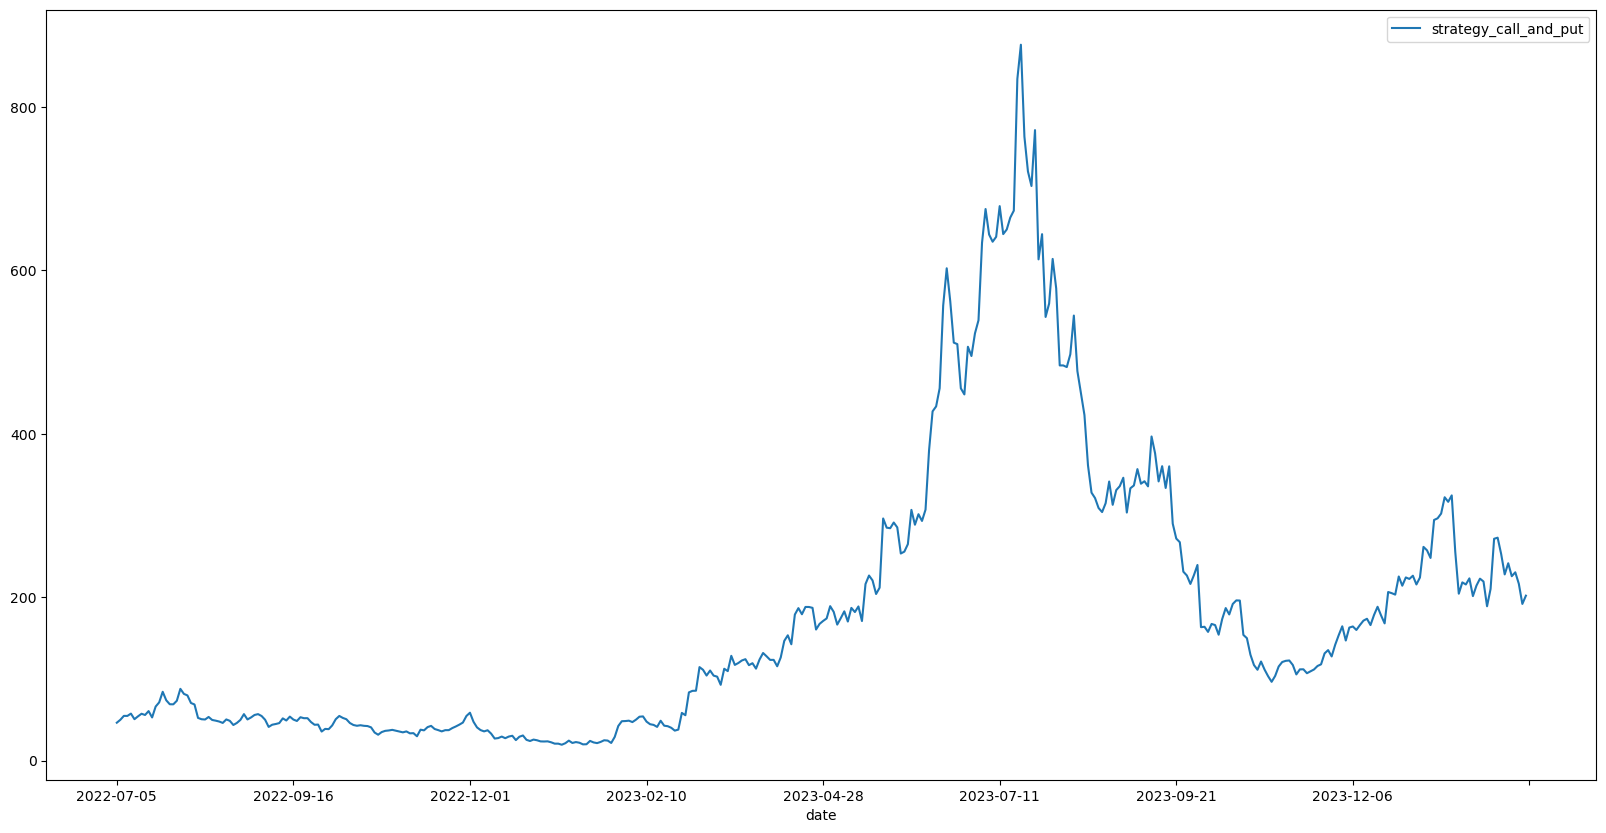

In [7]:
(1+selected_return_matrix).rolling(250).apply(lambda x: x.prod()).tail(400).plot(figsize=(20,10))

In [8]:
temp = summary.copy()
for metric in ['Sharpe', 'MDD', '250_Day_Median_Cumulative_Return', '60_Day_Median_Cumulative_Return',
               'Return', 'Last_250_Day_Cumulative_Return', 'Last_60_Day_Cumulative_Return']:
    temp = temp[temp[metric]>=temp[metric].quantile(0.7)]
    
temp

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,2.41194,1.65246,1.65403,4.04978,0.08962,5.16433,7.51642,43.12742,0.39288,0.00632,2.52392,9.75092,-0.91781,1,5
call_-1.5_-0.5,2.88165,1.61698,1.57534,3.36250,0.15774,5.43983,6.13687,23.96734,0.69296,0.00644,2.49624,8.15132,-0.84901,1,7
call_-1.5_-0.5,2.89580,1.62745,1.58237,3.33395,0.14888,5.49818,6.29523,24.28726,0.72900,0.00648,2.47670,8.15666,-0.85545,1,8
call_-1.5_-0.5,2.96042,1.64273,1.59718,3.41049,0.15214,5.71134,6.47297,23.60267,0.76117,0.00664,2.50987,8.43057,-0.85156,1,9
call_-1.5_-0.25,2.46822,1.65674,1.67430,4.29107,0.07976,5.29917,7.89729,46.94632,0.39106,0.00652,2.64052,8.79743,-0.92267,1,9
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.96488,1.68826,1.60692,3.76152,0.12550,5.69912,6.53172,23.45046,0.60300,0.00660,2.44790,8.56637,-0.87758,1,14
call_-1.5_-0.5,2.89145,1.63445,1.59055,3.74109,0.14625,5.52317,6.35111,23.11212,0.72367,0.00646,2.45288,8.64560,-0.85689,7,10
call_-1.5_-0.5,2.96304,1.63815,1.61588,4.25369,0.14969,5.60400,6.86954,33.19288,0.68215,0.00665,2.44760,8.76972,-0.85660,8,10
call_-1.5_-0.25,2.42989,1.65061,1.69130,5.58834,0.08125,5.04469,8.32952,48.59273,0.35529,0.00641,2.49579,8.49343,-0.92076,8,10


In [9]:
summary.sort_values("Sharpe", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1,5.18354,1.51824,1.49115,2.24286,0.44260,4.80782,5.15393,12.14021,1.57395,0.00640,2.19262,7.12824,-0.62848,1,13
call_-1.5_-1,5.17766,1.52537,1.50026,2.30281,0.45723,4.90544,5.25003,12.45917,1.60536,0.00649,2.21822,7.43860,-0.62198,13,13
call_-1.5_-1,5.17197,1.51709,1.48867,2.25350,0.43793,4.80942,5.11083,11.74262,1.59427,0.00637,2.21867,7.20524,-0.62148,1,14
call_-1.5_-1,5.16287,1.52084,1.49542,2.26430,0.44859,4.71860,5.22431,14.97990,1.59323,0.00642,2.18753,7.20224,-0.62923,8,13
call_-1.5_-1,5.16112,1.52198,1.49793,2.31406,0.44564,4.89883,5.20979,12.09610,1.62073,0.00647,2.24610,7.55443,-0.61856,13,14


In [10]:
summary.sort_values("MDD", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1.25,2.16061,1.09991,1.08554,1.35205,0.61035,1.34010,1.39810,2.48500,0.83957,0.00134,1.32947,1.74116,-0.39911,19,3
call_-1.5_-1.25,2.07911,1.10074,1.08428,1.35329,0.61216,1.33669,1.39091,2.49261,0.83160,0.00132,1.33237,1.75287,-0.40049,19,4
call_-1.5_-1.25,2.05420,1.10217,1.08400,1.36562,0.61202,1.35099,1.38877,2.48614,0.83682,0.00132,1.34996,1.79524,-0.40060,19,5
call_-1.5_-1.25,2.09267,1.09628,1.08239,1.35170,0.60559,1.32625,1.37725,2.40341,0.84645,0.00130,1.32955,1.75000,-0.40105,20,3
call_-1.5_-1.25,2.10462,1.10407,1.08580,1.36877,0.61216,1.35658,1.39751,2.49307,0.84759,0.00135,1.35250,1.81519,-0.40118,18,5


In [11]:
summary.sort_values("60_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,2.45920,1.70598,1.68593,4.52205,0.06682,5.46137,8.03962,45.47322,0.28487,0.00647,2.48296,8.45054,-0.93500,1,13
call_-1.5_-0.25,2.50217,1.70004,1.69153,4.33365,0.07633,5.75317,8.25088,47.14793,0.34294,0.00662,2.64031,9.53404,-0.92562,1,10
call_-1.5_-0.25,2.44542,1.69948,1.68401,4.16664,0.06943,5.61074,8.24670,48.48097,0.29097,0.00645,2.40130,7.94329,-0.93249,1,12
call_-1.5_-0.25,2.42569,1.69802,1.67859,4.73372,0.06930,5.20360,7.91639,45.98804,0.30086,0.00637,2.52003,8.17896,-0.93306,1,14
call_-1.5_-0.25,2.39393,1.69445,1.69221,5.89379,0.06918,4.81561,8.01741,47.48681,0.40843,0.00632,2.42832,7.38528,-0.93373,13,14


In [12]:
summary.sort_values("60_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,1.61213,1.50535,1.75819,8.74770,0.02025,2.44461,8.98798,88.95372,0.08458,0.00447,2.80782,4.56882,-0.98052,13,10
call_-1.5_0.25,1.65811,1.50399,1.75365,7.11353,0.02011,2.88857,9.38875,90.28639,0.05765,0.00467,2.97194,5.45547,-0.98071,1,10
call_-1.5_0.25,1.56881,1.46450,1.74844,9.35881,0.01967,2.19593,9.06528,102.48657,0.07774,0.00427,2.62087,3.48964,-0.98113,13,13
call_-1.5_0.25,1.54321,1.42749,1.74723,9.67174,0.02215,2.31658,9.88002,87.55378,0.06492,0.00414,2.76129,4.03426,-0.97867,8,10
call_-1.5_0.25,1.54068,1.47695,1.74694,9.95386,0.02045,2.13394,9.06700,103.62930,0.08372,0.00414,2.73190,3.30808,-0.98054,13,14


In [13]:
summary.sort_values("60_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.10839,0.75506,1.48479,25.48619,0.00334,0.10749,5.93767,252.26534,0.00052,-0.00681,2.46685,0.52207,-1.00000,18,27
call_-1.5_1.5,0.20044,0.78803,1.56536,24.74927,0.00292,0.13110,12.06196,449.53568,0.00059,-0.00601,2.46473,0.62657,-1.00000,8,27
call_-1.5_1.5,0.04639,0.72535,1.43372,24.61995,0.00339,0.10106,4.86023,215.33493,0.00046,-0.00732,2.62758,0.65138,-1.00000,18,26
call_-1.5_1.5,0.09972,0.74387,1.48729,24.54870,0.00314,0.09442,6.24859,264.56359,0.00060,-0.00688,2.50239,0.53549,-1.00000,18,29
call_-1.5_1.5,0.10143,0.75732,1.47428,24.35385,0.00311,0.10363,5.83294,241.86085,0.00057,-0.00686,2.42707,0.55489,-1.00000,18,28


In [14]:
summary.sort_values("60_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_1_1.25,-0.08437,0.96048,0.99422,1.50677,0.69133,0.80983,1.03176,3.02349,0.47833,-0.00024,1.17103,1.55200,-0.86386,18,4
put_1_1.25,-0.17741,0.95834,0.98876,1.50285,0.68919,0.80548,1.00800,2.84194,0.45626,-0.00033,1.16545,1.50177,-0.87579,18,3
put_1_1.25,-0.19234,0.95549,0.98776,1.52491,0.68701,0.79105,1.00657,2.90341,0.47806,-0.00035,1.17900,1.48949,-0.88135,19,3
put_1_1.25,-0.09907,0.95635,0.99340,1.55145,0.68449,0.80598,1.03247,3.11951,0.49998,-0.00026,1.18417,1.53316,-0.87026,19,4
put_1_1.25,-0.12093,0.96127,0.99074,1.47033,0.68288,0.81021,1.00228,2.70396,0.50305,-0.00028,1.20491,1.58262,-0.86120,16,4


In [15]:
summary.sort_values("250_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.93590,1.65777,1.60499,3.66793,0.13323,6.02139,6.59135,23.18986,0.64427,0.00658,2.36933,9.16968,-0.86923,9,12
call_-1.5_-0.5,2.95849,1.66437,1.60913,3.92553,0.12174,5.98552,6.53795,22.15182,0.60929,0.00661,2.43434,9.78922,-0.88056,9,13
call_-1.5_-0.5,2.99584,1.67920,1.61238,3.61779,0.12142,5.96619,6.64585,23.25626,0.58015,0.00666,2.40939,8.60921,-0.88105,1,13


In [16]:
summary.sort_values("250_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.66561,0.97638,1.69746,17.26608,0.00351,0.44872,14.46457,417.63715,0.00264,-0.00215,3.09206,1.88851,-0.99990,8,10
call_-1.5_1.5,0.61566,0.95771,1.71195,20.55613,0.00358,0.35580,13.59153,429.97922,0.00219,-0.00253,3.00295,1.44719,-0.99994,8,14
call_-1.5_1.5,0.57427,0.95918,1.67829,19.31850,0.00365,0.31425,13.39261,424.14976,0.00151,-0.00287,2.75045,1.32310,-0.99994,8,15
call_-1.5_1.5,0.64580,0.97740,1.69294,18.44973,0.00343,0.37769,13.15755,388.20755,0.00173,-0.00230,2.88729,1.54373,-0.99992,8,13
call_-1.5_1.5,0.63928,0.96377,1.65327,16.55356,0.00385,0.44713,12.95680,375.04263,0.00327,-0.00234,2.94032,1.33323,-0.99988,8,9


In [17]:
summary.sort_values("250_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.18988,0.77769,1.56959,23.46375,0.00268,0.11771,12.60400,455.92601,0.00069,-0.00610,2.50254,0.63970,-1.00000,8,29
call_-1.5_1.5,0.20044,0.78803,1.56536,24.74927,0.00292,0.13110,12.06196,449.53568,0.00059,-0.00601,2.46473,0.62657,-1.00000,8,27
call_-1.5_1.5,0.61566,0.95771,1.71195,20.55613,0.00358,0.35580,13.59153,429.97922,0.00219,-0.00253,3.00295,1.44719,-0.99994,8,14
call_-1.5_1.5,0.57427,0.95918,1.67829,19.31850,0.00365,0.31425,13.39261,424.14976,0.00151,-0.00287,2.75045,1.32310,-0.99994,8,15
call_-1.5_1.5,0.19155,0.79783,1.55438,23.45213,0.00267,0.12578,11.75410,422.91906,0.00065,-0.00607,2.41980,0.65982,-1.00000,8,28


In [18]:
summary.sort_values("250_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1,4.79915,1.48085,1.45819,2.20420,0.47651,4.22146,4.68566,10.65418,1.77674,0.00600,1.85993,5.95818,-0.61564,18,1
call_-1.5_-1,4.78764,1.48303,1.45824,2.19501,0.46654,4.29190,4.68560,10.81036,1.73180,0.00600,1.87364,6.07374,-0.62265,17,1
call_-1.5_-1,4.93142,1.48869,1.46303,2.15632,0.47730,4.36954,4.74996,11.14437,1.71848,0.00608,1.98814,6.48639,-0.60953,18,2
call_-1.5_-1,4.85968,1.48551,1.46169,2.24552,0.47470,4.29741,4.70842,11.40425,1.71517,0.00606,1.93312,6.51005,-0.61715,13,1
call_-1.5_-1,4.87741,1.47820,1.45788,2.11017,0.47566,4.26069,4.69504,11.30915,1.70778,0.00603,1.99488,6.40536,-0.60701,19,2


In [19]:
summary.sort_values("Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.5,2.99542,1.66833,1.62672,4.11326,0.14646,5.87196,6.91323,24.81686,0.77810,0.00677,2.47369,8.84172,-0.85618,13,10
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.98889,1.67508,1.62809,4.31498,0.12487,5.94953,6.83356,24.44636,0.72940,0.00672,2.34602,8.38867,-0.87767,13,13
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.5,2.96014,1.67326,1.62310,4.04587,0.13205,5.96177,6.87928,25.41189,0.74117,0.00668,2.28134,7.87340,-0.87055,13,12


In [20]:
summary.sort_values("Last_60_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.58821,0.95895,1.71412,16.56018,0.00153,0.48712,10.27176,247.89735,0.00126,-0.00325,4.76149,2.94139,-1.00000,30,10
call_-1.5_1.5,0.53811,0.90803,1.71106,14.77882,0.00159,0.41906,9.70450,252.48431,0.00087,-0.00369,4.57950,2.21850,-1.00000,30,14
call_-1.5_1.5,0.56856,0.94402,1.67377,17.89181,0.00174,0.51156,9.27199,227.44661,0.00136,-0.00340,4.54647,2.09608,-0.99999,30,9
call_-1.5_1.5,0.57089,0.94286,1.70458,15.48402,0.00158,0.41617,9.55507,229.72814,0.00107,-0.00343,4.42666,2.37624,-1.00000,30,13
call_-1.5_1.5,0.21404,0.77739,1.52420,14.57195,0.00139,0.19788,7.14423,179.89883,0.00028,-0.00665,4.31574,1.41622,-1.00000,30,24


In [21]:
summary.sort_values("Last_250_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,2.36565,1.64674,1.64185,4.40213,0.09450,5.32738,7.16669,40.09559,0.37160,0.00620,2.54072,11.00444,-0.91400,9,5
call_-1.5_-0.25,2.44747,1.68354,1.67918,4.79943,0.07758,5.75155,7.83500,42.95077,0.37501,0.00647,2.67490,10.87554,-0.92421,9,10
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.25,2.33805,1.64104,1.62374,4.47682,0.09533,4.91366,6.91663,35.86719,0.35031,0.00609,2.46583,10.29342,-0.91204,9,4
call_-1.5_-0.5,2.84699,1.64173,1.57563,3.50691,0.16535,5.55520,6.09370,21.78681,0.68599,0.00636,2.38905,10.28158,-0.84629,9,5
